In [2]:
# create vects from a game of thrones dataset
# and analize them to see sematic similarity
from __future__ import absolute_import, division, print_function # connection between python2 and 3
import codecs #for word enconding
import glob #regex
import multiprocessing #concurrency
import os # dealing with operatin system, like reading a file
import pprint #pretty printing, human radable
import re # regular expression
import nltk # natural language processing
import gensim.models.word2vec as w2v #word 2 vec
import sklearn.manifold #dimensionality reduction
import numpy as np #math
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns #visualization

In [3]:
#step 1 process our data
#clean data
nltk.download('punkt') #pre trained tokenizer
nltk.download('stopwords') #words like and, the, an, a, of

[nltk_data] Downloading package punkt to /home/dan/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /home/dan/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [4]:
#get the book names, matching txt file
book_filenames = sorted(glob.glob("./data/*.txt"))
print(book_filenames)

['./data/got1.txt', './data/got2.txt', './data/got3.txt', './data/got4.txt', './data/got5.txt']


In [5]:
corpus_raw = u"" #unicode string
for book_filename in book_filenames:
    print("Reading '{0}'...".format(book_filename))
    with codecs.open(book_filename, "r", "utf-8") as book_file:
        corpus_raw += book_file.read()
    print("Corpus is now {0} characters long".format(len(corpus_raw)))
    print()

Reading './data/got1.txt'...
Corpus is now 1770659 characters long

Reading './data/got2.txt'...
Corpus is now 4071041 characters long

Reading './data/got3.txt'...
Corpus is now 6391405 characters long

Reading './data/got4.txt'...
Corpus is now 8107945 characters long

Reading './data/got5.txt'...
Corpus is now 9719485 characters long



In [6]:
tokenizer = nltk.data.load('tokenizers/punkt/english.pickle') # pretrained model, turns up words into a tokens

In [7]:
raw_sentences = tokenizer.tokenize(corpus_raw) #tokenize corpus in sentences

In [8]:
#convert into a list of words
#rtemove unnnecessary,, split into words, no hyphens
#list of words
def sentence_to_wordlist(raw):
    #print(raw)
    clean = re.sub("[^a-zA-Z]"," ", raw)
    #print(clean)
    words = clean.split()
    return words

In [9]:
#sentence where each word is tokenized
sentences = []
for raw_sentence in raw_sentences:
    #print("raw_sentence:",raw_sentence)
    if len(raw_sentence) > 0:
        sentences.append(sentence_to_wordlist(raw_sentence))
#sentences

In [10]:
print(raw_sentences[5])
print(sentence_to_wordlist(raw_sentences[5]))

Heraldic crest by Virginia Norey.
['Heraldic', 'crest', 'by', 'Virginia', 'Norey']


In [11]:
token_count = sum([len(sentence) for sentence in sentences])
print("The book corpus contains {0:,} tokens".format(token_count))

The book corpus contains 1,818,103 tokens


In [12]:
#ONCE we have vectors
#step 3 - build model
#3 main tasks that vectors help with
#DISTANCE, SIMILARITY, RANKING

# Dimensionality of the resulting word vectors.
#more dimensions, more computationally expensive to train
#but also more accurate
#more dimensions = more generalized
num_features = 300
# Minimum word count threshold.
min_word_count = 3

# Number of threads to run in parallel.
#more workers, faster we train
num_workers = multiprocessing.cpu_count()

# Context window length.
context_size = 7

# Downsample setting for frequent words.
#0 - 1e-5 is good for this
downsampling = 1e-3

# Seed for the RNG, to make the results reproducible.
#random number generator
#deterministic, good for debugging
seed = 1

In [12]:
thrones2vec = w2v.Word2Vec( #initilize the model
    sg=1,
    seed=seed,
    workers=num_workers,
    size=num_features,
    min_count=min_word_count,
    window=context_size,
    sample=downsampling
)

In [13]:
thrones2vec.build_vocab(sentences)

In [14]:
print("Word2Vec vocabulary length:", len(thrones2vec.wv.vocab))

Word2Vec vocabulary length: 17277


In [15]:
thrones2vec.train(sentences, total_examples=thrones2vec.corpus_count, epochs=thrones2vec.iter) #training model

7023159

In [16]:
if not os.path.exists("trained"): #makes a trained directory
    os.makedirs("trained")

In [17]:
thrones2vec.save(os.path.join("trained", "thrones2vec.w2v")) # saves the trained model

In [13]:
thrones2vec = w2v.Word2Vec.load(os.path.join("trained", "thrones2vec.w2v")) #loads trained the model

In [19]:
# t stochastic distributed neighbor embedding for visualating  datasets with >2 dimention
tsne = sklearn.manifold.TSNE(n_components=2, random_state=0)

In [20]:
all_word_vectors_matrix = thrones2vec.wv.syn0 #puts all words in a vector
all_word_vectors_matrix

array([[-0.08150997, -0.07216346, -0.18255608, ...,  0.09567082,
        -0.16559952, -0.0690874 ],
       [ 0.07733495,  0.03261886,  0.04720843, ...,  0.15670739,
        -0.24166238, -0.05530888],
       [-0.10148485,  0.11023485,  0.05480693, ...,  0.07708509,
        -0.3266018 ,  0.16900414],
       ...,
       [-0.04730048,  0.026471  ,  0.01953401, ...,  0.05328269,
        -0.17310132,  0.03272212],
       [-0.02371497,  0.00851258,  0.03601015, ...,  0.01846423,
        -0.11994161,  0.03305788],
       [-0.03709193,  0.0034836 ,  0.00379872, ..., -0.01311422,
        -0.13087709, -0.01127677]], dtype=float32)

In [21]:
all_word_vectors_matrix_2d = tsne.fit_transform(all_word_vectors_matrix) #training the algorithm to see the array in 2d

In [27]:
points = pd.DataFrame(
    [
        (word, coords[0], coords[1])
        for word, coords in [
            (word, all_word_vectors_matrix_2d[thrones2vec.wv.vocab[word].index])
            for word in thrones2vec.wv.vocab
        ]
    ],
    columns=["word", "x", "y"]
)


In [28]:
points.head(10)

,word,x,y
0,This,35.924984,-28.548683
1,edition,-50.803341,-30.233662
2,the,16.433853,16.269361
3,complete,6.568707,-4.590731
4,of,-10.899920,-27.677614
5,original,-7.935107,-7.028401
6,hardcover,-48.506283,-28.073051
7,ONE,-40.466339,-36.800785
8,A,23.084461,8.876965
9,OF,-53.848534,-38.783676


In [29]:
sns.set_context("poster")

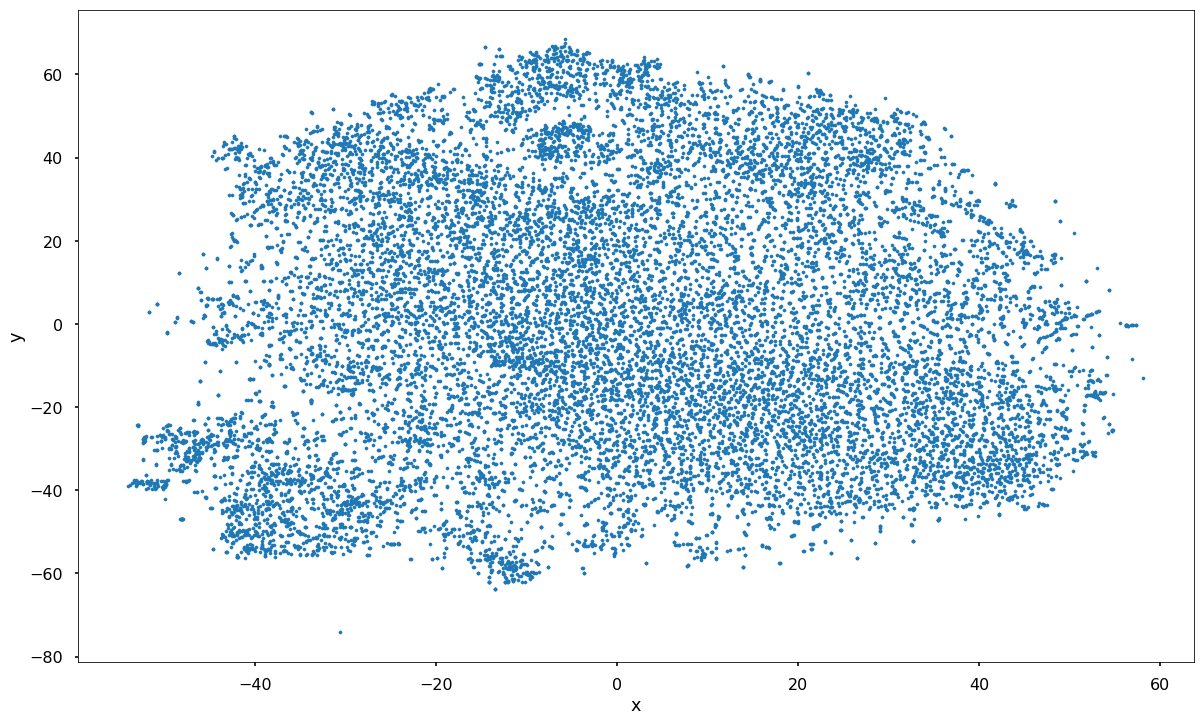

In [30]:
points.plot.scatter("x", "y", s=10, figsize=(20, 12)) #the words vectors in a gaph

In [33]:
# Zoom in to some interesting places
def plot_region(x_bounds, y_bounds):
    slice = points[
        (x_bounds[0] <= points.x) &
        (points.x <= x_bounds[1]) & 
        (y_bounds[0] <= points.y) &
        (points.y <= y_bounds[1])
    ]
    
    ax = slice.plot.scatter("x", "y", s=35, figsize=(10, 8))
    for i, point in slice.iterrows():
        ax.text(point.x + 0.005, point.y + 0.005, point.word, fontsize=11)

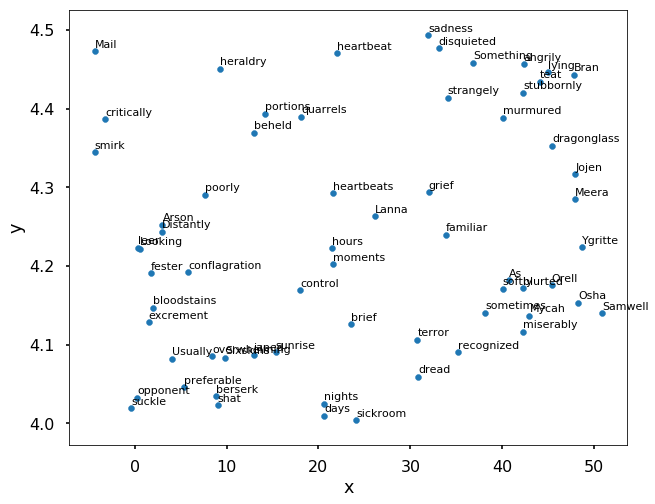

In [55]:
plot_region(x_bounds=(-5, 150), y_bounds=(4, 4.5))
#plot_region(x_bounds=(0, 1), y_bounds=(4, 4.5))

In [56]:
thrones2vec.most_similar("Stark")

[('Eddard', 0.7504149675369263),
 ('Winterfell', 0.6397874355316162),
 ('executed', 0.6372732520103455),
 ('beheaded', 0.6319105625152588),
 ('Brandon', 0.6296820044517517),
 ('Lyanna', 0.6282823085784912),
 ('Tully', 0.6181244850158691),
 ('Rickard', 0.6155304312705994),
 ('Hornwood', 0.6155227422714233),
 ('Karstark', 0.6108798384666443)]

In [61]:
thrones2vec.most_similar("Lannister")

[('pays', 0.668560802936554),
 ('Jaime', 0.6615517139434814),
 ('debts', 0.6500015258789062),
 ('Tywin', 0.6417127251625061),
 ('Kevan', 0.6362726092338562),
 ('Kingslayer', 0.6352681517601013),
 ('prisoner', 0.5926275253295898),
 ('Cersei', 0.5867859125137329),
 ('Imp', 0.5851666331291199),
 ('Rock', 0.583134114742279)]

In [62]:
thrones2vec.most_similar("dragon")

[('dragons', 0.6864986419677734),
 ('headed', 0.6212139129638672),
 ('Drogon', 0.6074668169021606),
 ('harpy', 0.6063767671585083),
 ('Targaryen', 0.5955560207366943),
 ('hatched', 0.5715289115905762),
 ('skulls', 0.5701006650924683),
 ('Viserys', 0.566986083984375),
 ('khal', 0.5589981079101562),
 ('khaleesi', 0.5507938265800476)]

In [14]:
thrones2vec.most_similar("wine")

[('cup', 0.8143112659454346),
 ('ale', 0.7705252766609192),
 ('flagon', 0.7675325870513916),
 ('mulled', 0.7402681112289429),
 ('drink', 0.7245602607727051),
 ('sip', 0.7138878107070923),
 ('drank', 0.7132524847984314),
 ('cups', 0.7008697390556335),
 ('beer', 0.699892520904541),
 ('dreamwine', 0.6822612881660461)]

In [15]:
# start1 is related with end1  as x is related with end2
#this function uses cosine similarity
def nearest_similarity_cosmul(start1, end1, end2):
    similarities = thrones2vec.most_similar_cosmul(
        positive=[end2, start1],
        negative=[end1]
    )
    start2 = similarities[0][0]
    print("{start1} is related to {end1}, as {start2} is related to {end2}".format(**locals()))
    return start2

In [16]:
nearest_similarity_cosmul("Stark", "Winterfell", "Riverrun")
nearest_similarity_cosmul("Jaime", "sword", "wine")
nearest_similarity_cosmul("Arya", "Nymeria", "dragons")

Stark is related to Winterfell, as Tully is related to Riverrun
Jaime is related to sword, as cup is related to wine
Arya is related to Nymeria, as Dany is related to dragons


'Dany'